# California Housing Analysis 
Since the objective is to prioritize potentially high-value areas, minimizing false negatives is more important than minimizing false positives. Therefore, recall for the positive class is chosen as the primary evaluation metric.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)

sns.set_context("notebook")

## Load Data

In [2]:
df = pd.read_csv("data/housing.csv")

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Create Binary Target

In [3]:
# Binary y/target creation from top 20% of median_house_value
threshold = df["median_house_value"].quantile(0.80)
y_full = (df["median_house_value"] >= threshold).astype(int)
y_full = pd.Series(y_full, name="high_value")

# Remove target column from features
X_full = df.drop(columns=["median_house_value"])

# Naming classes (for humans)
target_names = np.array(["not_high_value", "high_value"])

## EDA

,target,number,share
0,0,16510,0.799903
1,1,4130,0.200097


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

total_bedrooms        0.010029
longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

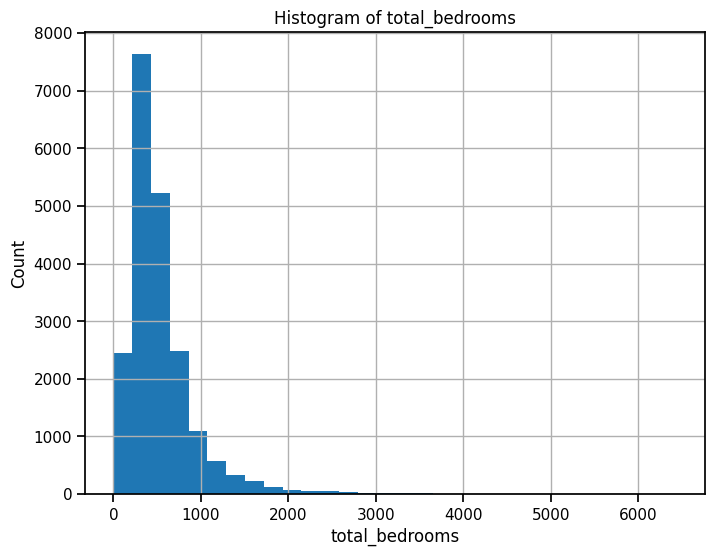

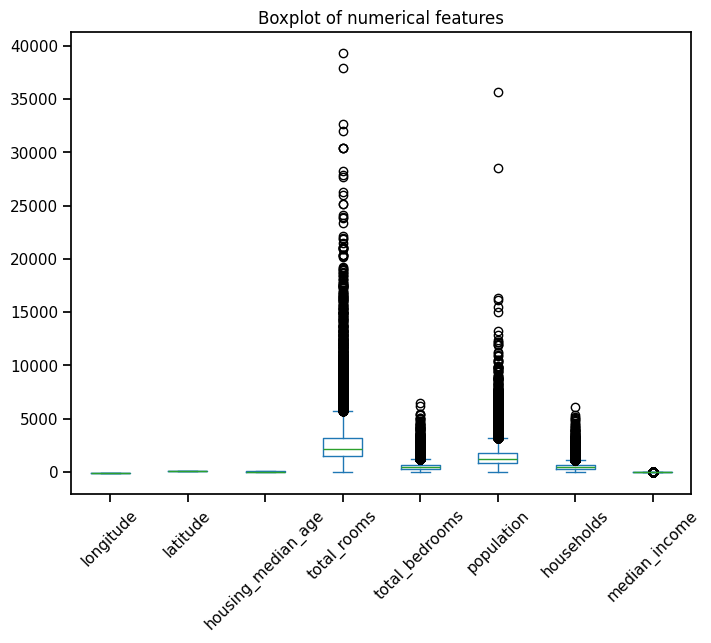

In [4]:
counts = pd.Series(y_full).value_counts().sort_index()
display(pd.DataFrame({
    "target": counts.index,
    "number": counts.values,
    "share": (counts.values / counts.values.sum())
}))

display(X_full.describe())

display(df.isna().sum())
display(df.isna().mean().sort_values(ascending=False))

X_full["total_bedrooms"].hist(bins=30, figsize=(8, 6))
plt.title("Histogram of total_bedrooms")
plt.xlabel("total_bedrooms")
plt.ylabel("Count")
plt.show()

X_full.select_dtypes(include="number").plot(kind="box", figsize=(8, 6))
plt.title("Boxplot of numerical features")
plt.xticks(rotation=45)
plt.show()

### EDA Summary
The EDA confirmed that a binary target was created based on the top 20% of median house values, resulting in an approximate 80/20 class distribution.  

The feature total_bedrooms contains about 1% missing values. Since the variable is numerically skewed, median imputation is considered an appropriate and robust strategy.  

The boxplots of numerical features reveal skewed distributions, large variation in raw totals, and several extreme values. As many features represent aggregated totals, this motivates the creation of ratio-based features (e.g., per household measures) in the next step.

## Feature Engineering

In [5]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

X_eng = df.drop(columns=["median_house_value"])

print(f"X rows:", X_eng.shape[0], "X columns:", X_eng.shape[1],"\ny rows:", y_full.shape[0])

display(X_eng.describe())

X rows: 20640 X columns: 12 
y rows: 20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,141.909091,1.000000,1243.333333


## Train / Validation / Test Split

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_eng, y_full,
    test_size=0.40,
    random_state=42,
    stratify=y_full
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

print ("\nClass distribution in train:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in validation:")
print(y_val.value_counts(normalize=True))
print("\nClass distribution in test:")
print(y_test.value_counts(normalize=True))

Train: (12384, 12) (12384,)
Validation: (4128, 12) (4128,)
Test: (4128, 12) (4128,)

Class distribution in train:
high_value
0    0.799903
1    0.200097
Name: proportion, dtype: float64

Class distribution in validation:
high_value
0    0.799903
1    0.200097
Name: proportion, dtype: float64

Class distribution in test:
high_value
0    0.799903
1    0.200097
Name: proportion, dtype: float64


## Validating Feature Engineering after Split

In [7]:
train_df = pd.concat([X_train, y_train], axis=1)
corr_target = train_df.corr(numeric_only=True)["high_value"].sort_values(ascending=False)
print(corr_target)

high_value                  1.000000
median_income               0.547326
rooms_per_household         0.158246
housing_median_age          0.101428
total_rooms                 0.095064
households                  0.022043
total_bedrooms              0.014834
population_per_household   -0.017730
population                 -0.050882
latitude                   -0.058320
longitude                  -0.061977
bedrooms_per_room          -0.223131
Name: high_value, dtype: float64


### Validating Feature Engineering Summary
The correlation analysis (train set) shows that median_income has the strongest positive relationship with the target. Engineered features such as rooms per household show stronger association than raw totals, supporting the feature engineering step.

## Help Function for Evaluating Classification

In [8]:
def evaluate_classification(y_true, y_pred) -> dict:
   
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

## Dummy Baseline

Baseline from validation data: {'accuracy': 0.7999031007751938, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


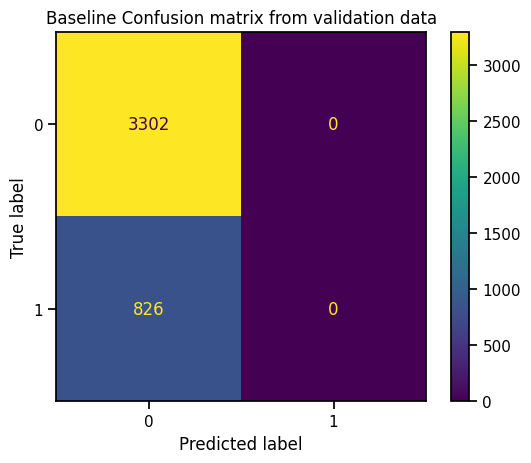

In [9]:
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)

y_pred_base_val = baseline.predict(X_val)
print("Baseline from validation data:", evaluate_classification(y_val, y_pred_base_val))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_base_val)
plt.title("Baseline Confusion matrix from validation data")
plt.show()

## Preprocessing
For the non-numerical feature ocean proximity OneHotEncoder is used.  
Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [10]:
numeric_features = X_train.select_dtypes(include="number").columns
categorical_features = X_train.select_dtypes(exclude="number").columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Training Models on Test Data


In [12]:
models = {}

logreg = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("model", LogisticRegression(
        max_iter=5000,
        random_state=42
    ))
])

models["LogReg"] = logreg

knn = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", KNeighborsClassifier())
])

models["KNN"] = knn

tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(
        random_state=42,
        max_depth=3))
])

models["Tree"] = tree

ranfor = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

models["Random Forest"] = ranfor

rows = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    rows.append({"model": name, **evaluate_classification(y_val, y_pred_val)})

results_val = pd.DataFrame(rows).sort_values("recall", ascending=False)
results_val

,model,accuracy,precision,recall,f1
3,Random Forest,0.917878,0.859675,0.704600,0.774451
0,LogReg,0.890262,0.790047,0.615012,0.691627
1,KNN,0.885174,0.789474,0.581114,0.669456
2,Tree,0.854893,0.844985,0.336562,0.481385
